In [1]:
library(ggplot2)
library(dplyr)
library(readr)
library(DESeq2)
library(DiffBind)
library(tidyr)
library(wesanderson)
library(viridis)
library(gplots)
library(pheatmap)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter,

In [3]:
setwd('/lustre1/project/stg_00041/Irene/bulkRNAseq_primed_naive_PRC2i_2020/featureCount/')

In [4]:
gene_raw_counts_ordered <- read.delim("gene_raw_counts_ordered.txt")

In [8]:
head(gene_raw_counts_ordered)

GeneID,primed_rep1,primed_rep2,primed_rep3,primed_PRC2i_rep1,primed_PRC2i_rep2,primed_PRC2i_rep3,naive_rep1,naive_rep2,naive_rep3,naive_PRC2i_rep1,naive_PRC2i_rep2,naive_PRC2i_rep3
DDX11L1,1,0,0,0,0,0,0,0,0,0,0,0
WASH7P,0,0,1,2,1,0,0,1,1,0,1,0
MIR6859-1,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
rownames(gene_raw_counts_ordered) <- gene_raw_counts_ordered[,1]

In [11]:
gene_raw_counts_ordered$GeneID <- NULL

In [12]:
head(gene_raw_counts_ordered)

,primed_rep1,primed_rep2,primed_rep3,primed_PRC2i_rep1,primed_PRC2i_rep2,primed_PRC2i_rep3,naive_rep1,naive_rep2,naive_rep3,naive_PRC2i_rep1,naive_PRC2i_rep2,naive_PRC2i_rep3
DDX11L1,1,0,0,0,0,0,0,0,0,0,0,0
WASH7P,0,0,1,2,1,0,0,1,1,0,1,0
MIR6859-1,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
condition <- c("primed","primed","primed","primed_PRC2i","primed_PRC2i","primed_PRC2i","naive","naive","naive","naive_PRC2i","naive_PRC2i","naive_PRC2i")

In [16]:
colData2 <- data.frame(condition,row.names=colnames(gene_raw_counts_ordered))
# colData$condition <- factor(c("primed_rep1","primed_rep2","primed_rep3","primed_PRC2i_rep1","primed_PRC2i_rep2", "primed_PRC2i_rep3","naive_rep1","naive_rep2","naive_rep3","naive_PRC2i_rep1","naive_PRC2i_rep2", "naive_PRC2i_rep3"), levels = c("primed","primed_PRC2i","naive","naive_PRC2i"))

In [17]:
colData2

,condition
primed_rep1,primed
primed_rep2,primed
primed_rep3,primed
primed_PRC2i_rep1,primed_PRC2i
primed_PRC2i_rep2,primed_PRC2i
primed_PRC2i_rep3,primed_PRC2i
naive_rep1,naive
naive_rep2,naive
naive_rep3,naive
naive_PRC2i_rep1,naive_PRC2i


In [18]:
dds_unbiased <- DESeqDataSetFromMatrix(countData = gene_raw_counts_ordered, colData = colData2, design = ~ 1)

only keep rows that at least 2 conditions have >1 counts

In [19]:
dds_unbiased <- dds_unbiased[ rowSums(counts(dds_unbiased)>1) >=2, ] 

In [20]:
dds_unbiased

class: DESeqDataSet 
dim: 30348 12 
metadata(1): version
assays(1): counts
rownames(30348): CICP27 AL627309.6 ... MT-TT MT-TP
rowData names(0):
colnames(12): primed_rep1 primed_rep2 ... naive_PRC2i_rep2
  naive_PRC2i_rep3
colData names(1): condition

Normalize with rlog for PCA. rlog transforms the count data to the log2 scale in a way which minimizes differences between samples for rows with small counts, and which normalizes with respect to library size.

In [21]:
rld <- rlog(dds_unbiased, blind = TRUE)

In [22]:
nrow(rld)

[1] 30348

In [37]:
options(repr.plot.width=5, repr.plot.height=4)

PCA_all_counts <- plotPCA(rld, intgroup = c("condition"), ntop=30348)+
  #scale_color_manual(values = c("naive" = "#7EC247", "naive_PRC2i" = "#7EC247", "primed" = "#54A3DA", "primed_PRC2i" = "#54A3DA")) +
  scale_shape_manual(values = c("naive" = 16, "naive_PRC2i" = 1, "primed" = 16, "primed_PRC2i" = 1)) +
ylim(-100,100)+
ggtitle("Transcriptomics") +
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust = 0.5)) +
    theme_bw(base_size = 16) +
    theme(legend.title=element_blank())+
    xlab("PC1 (79%)") +
    ylab("PC2 (3%)")+
   # theme(axis.text.x  = element_text(angle=0, vjust=0.5, hjust=0.5, size=8, colour = "black"))+
    #theme(axis.text.y  = element_text(angle=0, vjust=0.5, hjust=0.5, size=8, colour = "black"))+
    theme(axis.line = element_line(colour = "black"))

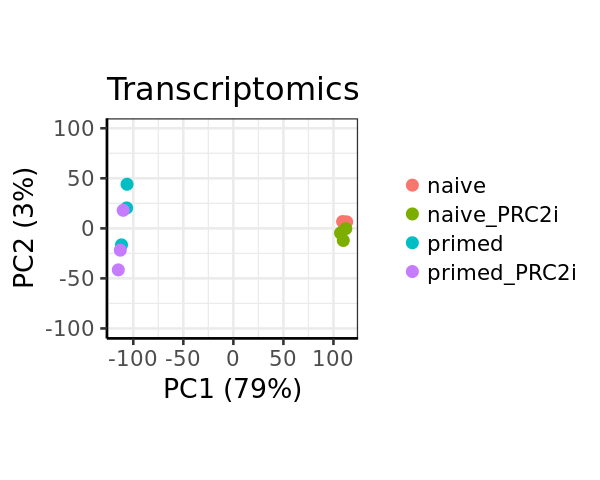

In [38]:
PCA_all_counts